# Handling multiple samples within a single simulation run

SEM also provides support for dealing with simulations that may yield multiple samples per simulation run. This example showcases this functionality.

In [1]:
import sem
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
ns_path = 'ns-3'
script = 'main-propagation-loss-no-gnuplot'
campaign_dir = "results-propagation-loss"
campaign = sem.CampaignManager.new(ns_path, script, campaign_dir)

In [3]:
print(campaign)

--- Campaign info ---
script: main-propagation-loss-no-gnuplot
params: {'LossModel': 'Friis', 'Samples': 10.0}
HEAD: 6aae3d04c51af2f60daabc9dd9da120a838623c0
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


In [4]:
params = {
    'LossModel': ['Friis', 
                  'LogDistance', 
                  'Random', 
                  'ThreeLogDistance', 
                  'ThreeLogDistanceDifferentExponents', 
                  'Nakagami', 
                  'ThreeLogDistanceAndNakagami'],
    'Samples': [10000]
}
campaign.run_missing_simulations(params, runs=1)

In [5]:
example_result = campaign.db.get_complete_results(params)[0]

In [6]:
example_result['output']['stdout'].splitlines()[:10]

['100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777',
 '100 -46.6777']

Now, let's define a parsing function to extract the data:

In [7]:
@sem.utils.yields_multiple_results
@sem.utils.output_labels(['Distance [m]', 'Receive Power [dBm]'])
@sem.utils.only_load_some_files(r'.*stdout.*')
def get_propagation_samples(result):
    data = []
    for line in result['output']['stdout'].splitlines():
        data += [[float (i) for i in line.split(" ")]]
    return data

Note the use of the `@sem.utils.yields_multiple_results` decorator to mark the function, which in fact returns multiple samples in an array:

In [8]:
display(get_propagation_samples(example_result))

[[100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],
 [100.0, -46.6777],


When we provide the `get_propagation_samples` to `get_results_as_dataframe`, the output will feature more than 1 line per parameter combination. Also note how we enable parallel parsing in the following cell:

In [9]:
data = campaign.get_results_as_dataframe(get_propagation_samples,
                                         params=params,
                                         verbose=True,
                                         parallel_parsing=True)

Parsing Results: 100%|██████████| 7/7 [00:02<00:00,  2.41result/s]


In [10]:
display(data)

,LossModel,Samples,RngRun,Distance [m],Receive Power [dBm]
0,LogDistance,10000,1,100.0,-76.67770
1,LogDistance,10000,1,100.0,-76.67770
2,LogDistance,10000,1,100.0,-76.67770
3,LogDistance,10000,1,100.0,-76.67770
4,LogDistance,10000,1,100.0,-76.67770
...,...,...,...,...,...
1329995,Nakagami,10000,5,1900.0,12.26070
1329996,Nakagami,10000,5,1900.0,14.47580
1329997,Nakagami,10000,5,1900.0,9.88632
1329998,Nakagami,10000,5,1900.0,21.36620


## Influence of distance on propagation models

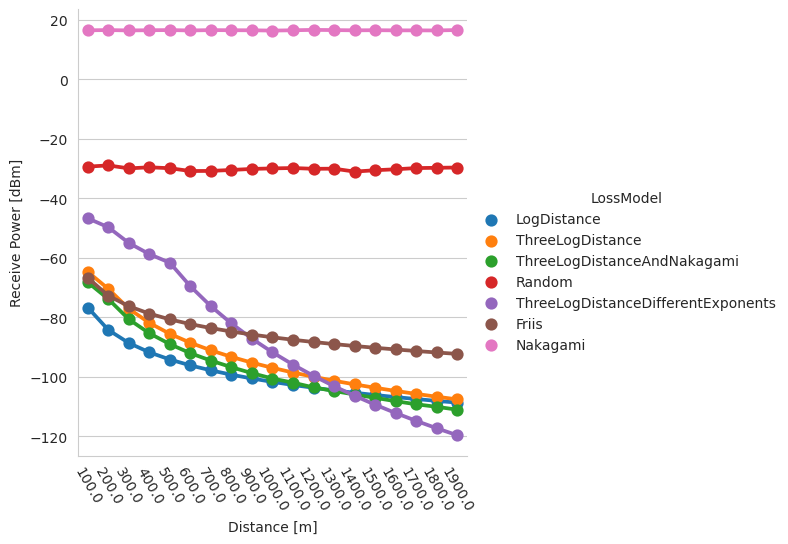

In [11]:
g = sns.catplot(data=data,
           x='Distance [m]',
           y='Receive Power [dBm]',
           hue='LossModel',
           kind='point')
g.set_xticklabels(rotation=-60)
plt.show()

## Box Plot of Receive Power Samples

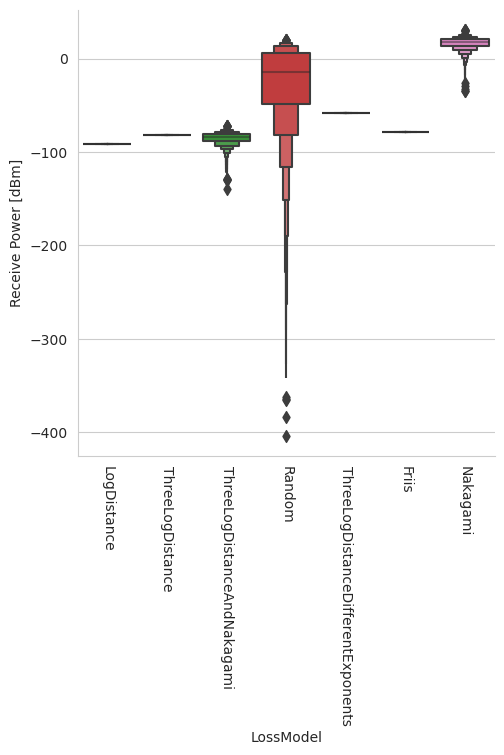

In [12]:
g = sns.catplot(data=data[(data['Distance [m]'] == 400)],
           x='LossModel',
           y='Receive Power [dBm]',
           kind='boxen')
g.set_xticklabels(rotation=-90)
plt.show()

## ECDF of Propagation Models for Various Distances

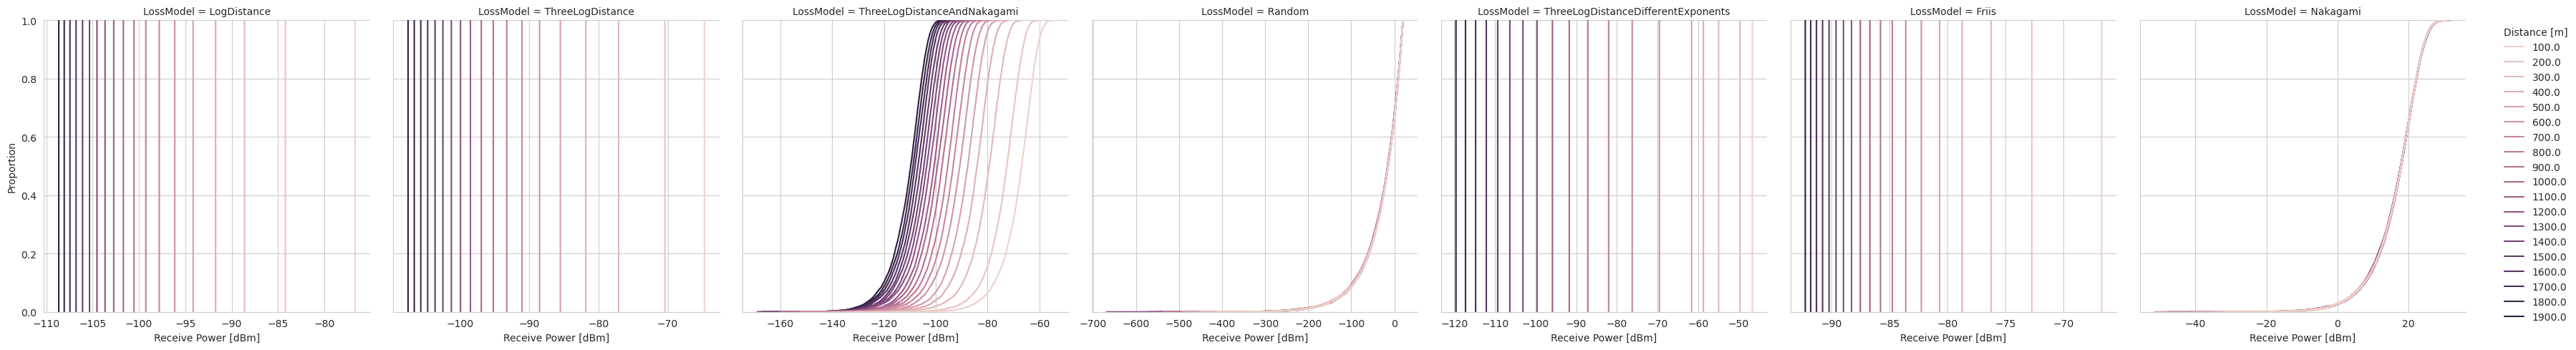

In [13]:
sns.displot(data=data,
            x='Receive Power [dBm]',
            hue='Distance [m]',
            col='LossModel',
            facet_kws={'sharex':False},
            kind='ecdf')
plt.show()